# Convert HDF5 files to pickeld Pandas Dataframes

This conversion isn't strictly necessary, but comes in handy for quickly reading the data for scikit-learn, ploting, etc.

In [1]:
import h5py
import numpy as np
import pandas as pd

In [2]:
MAX_NEUTRONS = 5

In [3]:
def create_pandas(infile, outfile):
    file = h5py.File(infile, "r")
    # Note: Data in HDF5 file is not in the native Pandas Dataframe format
    data = pd.DataFrame(np.array(file["data"]))
    data.columns = ["nPN", "nPP", "nPH", "nHits", "nClus", "Edep"]
    # Use MAX_NEUTRONS to test predictions for scenarios with limited number of neutrons
    # FIXME: nPH < nPN shouldn't be necessary, few cases (431/1M)
    idx = (data["nPN"] <= MAX_NEUTRONS) & (data["nPH"] <= data["nPN"])
    data = data[idx]
    print(f"{infile} -> {outfile}")
    data.to_pickle(outfile)

In [4]:
beam_energy = 600
for num_dp in [15, 30]:
    for dataset in ["training", "validation", "test"]:
        infile = f"data/{dataset}_{beam_energy}AMeV_{num_dp}dp.h5"
        outfile = f"data/{dataset}_{beam_energy}AMeV_{num_dp}dp.pkl"
        create_pandas(infile, outfile)

data/training_600AMeV_15dp.h5 -> data/training_600AMeV_15dp.pkl
data/validation_600AMeV_15dp.h5 -> data/validation_600AMeV_15dp.pkl
data/test_600AMeV_15dp.h5 -> data/test_600AMeV_15dp.pkl
data/training_600AMeV_30dp.h5 -> data/training_600AMeV_30dp.pkl
data/validation_600AMeV_30dp.h5 -> data/validation_600AMeV_30dp.pkl
data/test_600AMeV_30dp.h5 -> data/test_600AMeV_30dp.pkl


## Explore Datasets

In [5]:
data = pd.read_pickle(f"data/training_600AMeV_15dp.pkl")
print(data)

         nPN  nPP  nPH  nHits  nClus  Edep
0          1    1    0      0      0     0
1          1    1    1     14      4   157
2          1    1    1     25      4   431
3          1    1    1     29      4   466
4          1    1    1     10      3   211
...      ...  ...  ...    ...    ...   ...
4999995    5    4    4     68     28  1242
4999996    5    4    4     50     22   831
4999997    5    4    4     53     20  1098
4999998    5    5    5     76     27  1497
4999999    5    4    3     13     11    72

[4999744 rows x 6 columns]


In [6]:
r = range(1, 6)
hits = [
    np.histogram(
        data[data["nPH"] == n]["nHits"], range=(0, 150), bins=150, density=True
    )[0]
    for n in r
]
clus = [
    np.histogram(
        data[data["nPH"] == n]["nClus"], range=(0, 150), bins=150, density=True
    )[0]
    for n in r
]
edep = [
    np.histogram(
        data[data["nPH"] == n]["Edep"], range=(0, 2000), bins=200, density=True
    )[0]
    for n in r
]

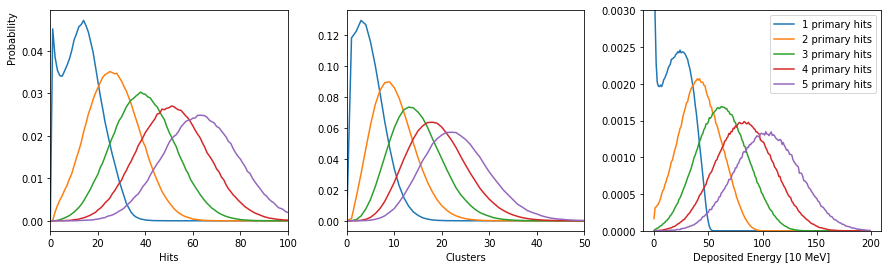

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2 * 6.224, 2 * (6.224 / 1.618 * 0.5)))

ax1 = fig.add_subplot(131)
ax1.set_xlim(0, 100)
for h in hits:
    ax1.plot(h)
ax1.set_ylabel(r"Probability", horizontalalignment="right", y=1)
ax1.set_xlabel(r"Hits")

ax2 = fig.add_subplot(132)
ax2.set_xlim(0, 50)
for c in clus:
    ax2.plot(c)
ax2.set_xlabel(r"Clusters")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0, 0.003)
for i, e in enumerate(edep, 1):
    ax3.plot(e, label=f"{i} primary hits")
ax3.set_xlabel(r"Deposited Energy [10 MeV]")

ax3.legend()

fig.tight_layout()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

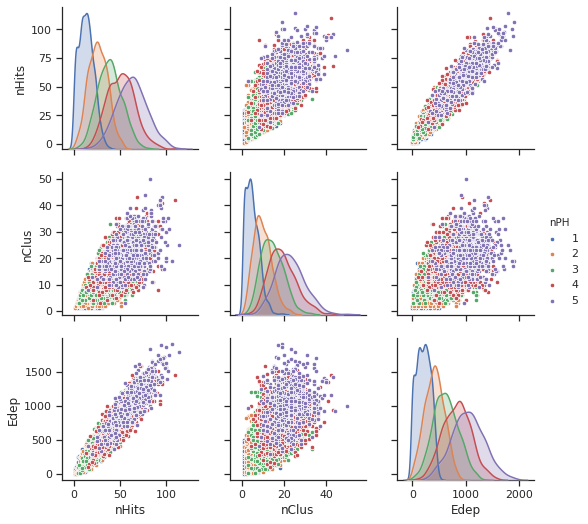

In [9]:
sample = data[data["nPH"] > 0].sample(frac=0.001)
sns.set(style="ticks", color_codes=True)
sns.pairplot(sample, vars=["nHits", "nClus", "Edep"], hue="nPH", plot_kws={"s": 20});